# <center>HW4</center>
### <center>106030012 廖昱瑋</center>
***

## (1)
Combine class value “unacc” and “acc” as one group, “good” and “vgood” as the other group, develop a model to identify the two groups.

## 想法
1. 採用support vector machine作為這次model的algorithm，因為SVM主要有兩個參數(C及gamma)可以調，適合套用到grid search上找出最好的parameter
2. 將非數字features，以OneHotEncoder轉換，並採用所有features
3. 需要決定的參數有sample數、"k"-fold cross validation、C、gamma

### 資料處理
1. 將label "unacc"、"acc"轉換為0，"good"、"vgood"轉換為1
2. 因為doors及persons feature數值有裡面又有包含文字，但又有大小之分，並不適合用OneHotEncoder，所以將doors中的5more及persons中的more轉換為5。因為這兩個features數值只有幾種，且數值上下界差異不大，所以不需要做standardization
3. 將buying、maint、lug_boot feature用OneHotEncoder方式，以pandas中的get_dummies轉換，設drop_first = True

做完轉換總共會有12種features

In [317]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', header = None)
df.columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'classlabel']

label_mapping = {'unacc': 0, 'acc': 0, 'good': 1, 'vgood': 1}
doors_mapping = {'2': 2, '3': 3, '4': 4, '5more': 5}
persons_mapping = {'2': 2, '4': 4, 'more': 5}

df['classlabel'] = df['classlabel'].map(label_mapping)
df['doors'] = df['doors'].map(doors_mapping)
df['persons'] = df['persons'].map(persons_mapping)
df = pd.get_dummies(df, drop_first=True)
print(df)

X = df.iloc[:, np.r_[0:2, 3:13]].values
y = df.iloc[:, 2].values

      doors  persons  classlabel  buying_low  buying_med  buying_vhigh  \
0         2        2           0           0           0             1   
1         2        2           0           0           0             1   
2         2        2           0           0           0             1   
3         2        2           0           0           0             1   
4         2        2           0           0           0             1   
...     ...      ...         ...         ...         ...           ...   
1723      5        5           1           1           0             0   
1724      5        5           1           1           0             0   
1725      5        5           0           1           0             0   
1726      5        5           1           1           0             0   
1727      5        5           1           1           0             0   

      maint_low  maint_med  maint_vhigh  lug_boot_med  lug_boot_small  \
0             0          0            

有1594個samples label為0、134個samples label為1  
比例相差太懸殊，所以使用resample方法，先把兩種labels都調成1594個，之後會藉由learning curve取適當的sample數，並取30%為test data，70%為training data  

In [318]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

print("number of labels before([label0 lable1]): %s"% np.bincount(y))

X1_upsampled, y1_upsampled = resample(X[y == 1],
                                      y[y == 1],
                                      replace=True,
                                      n_samples=1594,
                                      random_state=1)

X_resample = np.vstack((X[y==0], X1_upsampled))
y_resample = np.hstack((y[y==0], y1_upsampled))

print("number of labels after([label0 lable1]): %s"% np.bincount(y_resample))

X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, test_size=0.3, random_state=0, stratify=y_resample)

number of labels before([label0 lable1]): [1594  134]
number of labels after([label0 lable1]): [1594 1594]


接著，要決定sample數取多少比較合理。由於此時不知道SVC的參數要設多少，所以就先透過比較不需要設定那麼多種參數的logistic regression，初步取得合理的smple數及k    
用learning curve，以logistic regression model初步畫出sample v.s. accuracy圖，penalty設none(採用所有原始features)、先用10-fold cross-validation，取出適當的sample數

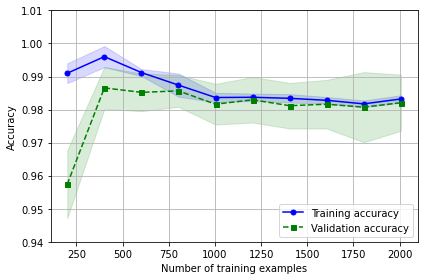

In [319]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=LogisticRegression(penalty='none', random_state=1, solver='lbfgs', max_iter=10000),
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.94, 1.01])
plt.tight_layout()
plt.show()

由上圖可知，在training sample數大約為750時，validation accuracy表現不錯、標準差不大且與training accuracy表現差不多，所以從原始data set取sample數為750/0.9/0.7 ≈ 1200  
將label為0及1的數目都調到600   
再重新分割data set，30%(360筆)為test data、70%(840筆)為training data

In [320]:
print("number of labels before([label0 lable1]): %s"% np.bincount(y))

X0_dwsampled, y0_dwsampled = resample(X[y == 0],
                                      y[y == 0],
                                      replace=True,
                                      n_samples=600,
                                      random_state=123)
X1_upsampled, y1_upsampled = resample(X[y == 1],
                                      y[y == 1],
                                      replace=True,
                                      n_samples=600,
                                      random_state=1)

X_resample = np.vstack((X0_dwsampled, X1_upsampled))
y_resample = np.hstack((y0_dwsampled, y1_upsampled))

print("number of labels after([label0 lable1]): %s"% np.bincount(y_resample))

X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, test_size=0.3, random_state=0, stratify=y_resample)

number of labels before([label0 lable1]): [1594  134]
number of labels after([label0 lable1]): [600 600]


## Train model
資料處理完後，以logistic regression model初步畫出k-fold v.s. accuracy圖，penalty設none(採用所有原始features)，找出k設多少比較好。最後，再用SVM train出最終model

(0.96, 1.01)

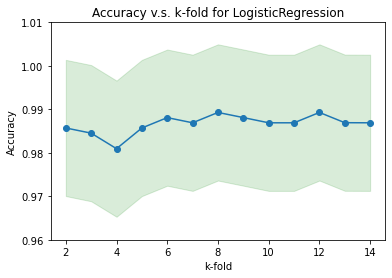

In [321]:
from sklearn.model_selection import cross_val_score

scores_mean, scores_std, params = [], [], []
for c in np.arange(2, 15, 1):
    scores = cross_val_score(estimator=LogisticRegression(penalty='none', random_state=1, solver='lbfgs', max_iter=10000),
                             X=X_train,
                             y=y_train,
                             cv=c,
                             n_jobs=-1)
    score_mean, score_std = np.mean(scores), np.std(scores)
    scores_mean.append(score_mean)
    scores_std.append(score_std)
    params.append(c)
scores = np.array(scores)    

plt.figure()
plt.title('Accuracy v.s. k-fold for LogisticRegression')
plt.plot(params, scores_mean, marker = 'o')
plt.fill_between(params,
                 scores_mean + score_std,
                 scores_mean - score_std,
                 alpha=0.15, color='green')
plt.xlabel('k-fold')
plt.ylabel('Accuracy')
plt.ylim([0.96, 1.01])

由上圖可知，不論k為多少，標準差都差不多，而k=8之後，accuracy表現比較穩定，所以我以4*2-fold corss validation去train model  
再使用support vector machine algorithm，透過grid search方法，找出最適當的kernel、gamma及hyperparameter

In [322]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(SVC(random_state=1, probability=True))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=2,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)
print("best accuracy in param_grid:",gs.best_score_)
print("best param_grid:",gs.best_params_)
clf = gs.best_estimator_

scores = cross_val_score(clf, X_train, y_train, 
                         scoring='accuracy', cv=4)

print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))

print('Test accuracy: %.3f' % clf.score(X_test, y_test))

best accuracy in param_grid: 0.9892857142857143
best param_grid: {'svc__C': 1000.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
CV accuracy: 0.992 +/- 0.004
Test accuracy: 1.000


從grid search可以得知，當hperparameter=1000、gamma=0.01、kernel='rbf'時，是最好的model，那個model的accuracy為98.93%  
再用nested cross validation去看training data CV的accuracy，可以得到accuracy為99.2%，標準差為0.004  
而test accuracy為100%

雖然已經得到nested cross validation的總體accuracy，但我再以原本只有2-fold cross validation情況下，最佳的model，去看他的confusoin matrix。

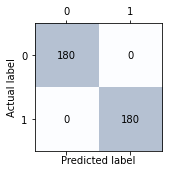

In [323]:
from sklearn.metrics import confusion_matrix

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

plt.tight_layout()
plt.show()

從confusion matrix可以得知，test data中有180筆TP、180筆TN

接著用nested cross validation中的內圈(2-fold cross validation)中的model，畫ROC及看ROC的AUC為多少

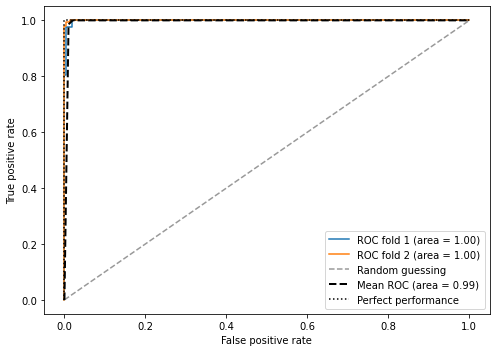

In [324]:
from sklearn.metrics import roc_curve, auc
from distutils.version import LooseVersion as Version
from scipy import __version__ as scipy_version
from sklearn.model_selection import StratifiedKFold

if scipy_version >= Version('1.4.1'):
    from numpy import interp
else:
    from scipy import interp
    

cv = list(StratifiedKFold(n_splits=2).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = clf.fit(X_train[train], y_train[train]).predict_proba(X_train[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

上圖可知，2個fold的AUC都達到將近1，平均area為0.99

## 結論
1. training data CV的accuracy為99.2%，標準差為0.004；test data的accuracy為100%。accuracy很高，且標準差很小，model表現還不錯
2. 計算的決定好要用750個samples及4*2-fold cross validation後，在grid search的地方，計算量需要  
    kernel: 2種、hyperparameter: 8種、gamma: 8種、cross validation: 4 * 2種  
    排列組合共為2 * 8 * 8 * 4 * 2=1024次，代表要計算1024次得到最佳parameter及CV accuracy
3. 因為最初要決定sample數及幾個fold cross validation時，不知道SVC的參數要設多少，所以就先透過比較不需要設定那麼多種參數的logistic regression，初步取得合理的sample數及k。雖然取得這兩個數字時和最終使用的model是不同algoriithm，但這兩個參數對整個model影響並不會很大，所以只是先取一個合理的數字
4. 資料處理時，有先將doors中的5more及persons中的more轉換為5，這個轉換可能不夠精準，但是doors及persons中的資料為numerical，又要將含有文字的部分轉換為數字，所以就只能先以這種方式轉換了。另外，因為這兩個features數值的上下界很小，也只有3、4種數值，所以就沒先做standardization  
---

## (2)
With the original four class values, develop a model to do multi-class classification of
the four groups. (All features used)

## 想法
1. 採用support vector machine作為這次model的algorithm，因為SVM主要有兩個參數(C及gamma)可以調，適合套用到grid search上找出最好的parameter
2. 將非數字features，以OneHotEncoder轉換，並採用所有features
3. 需要決定的參數有sample數、"k"-fold cross validation、C、gamma
4. 在logistic regression中multi-class用OVR方法、而SVM只有支援one-vs-one scheme

### 資料處理
1. 將label "unacc"轉換為0、"acc"轉換為1，"good"轉換為2、"vgood"轉換為3
2. 因為doors及persons feature數值有裡面又有包含文字，但又有大小之分，並不適合用OneHotEncoder，所以將doors中的5more及persons中的more轉換為5。因為這兩個features數值只有幾種，且數值上下界差異不大，所以不需要做standardization
3. 將buying、maint、lug_boot feature用OneHotEncoder方式，以pandas中的get_dummies轉換，設drop_first = True

做完轉換總共會有12種features

In [325]:
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', header = None)
df.columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'classlabel']

label_mapping = {'unacc': 0, 'acc': 1, 'good': 2, 'vgood': 3}
doors_mapping = {'2': 2, '3': 3, '4': 4, '5more': 5}
persons_mapping = {'2': 2, '4': 4, 'more': 5}

df['classlabel'] = df['classlabel'].map(label_mapping)
df['doors'] = df['doors'].map(doors_mapping)
df['persons'] = df['persons'].map(persons_mapping)
df = pd.get_dummies(df, drop_first=True)
print(df)

X = df.iloc[:, np.r_[0:2, 3:13]].values
y = df.iloc[:, 2].values

      doors  persons  classlabel  buying_low  buying_med  buying_vhigh  \
0         2        2           0           0           0             1   
1         2        2           0           0           0             1   
2         2        2           0           0           0             1   
3         2        2           0           0           0             1   
4         2        2           0           0           0             1   
...     ...      ...         ...         ...         ...           ...   
1723      5        5           2           1           0             0   
1724      5        5           3           1           0             0   
1725      5        5           0           1           0             0   
1726      5        5           2           1           0             0   
1727      5        5           3           1           0             0   

      maint_low  maint_med  maint_vhigh  lug_boot_med  lug_boot_small  \
0             0          0            

有1210個samples label為0、384個samples label為1、69個samples label為3、65個samples label為4  
比例相差太懸殊，所以使用resample方法，先把四種labels都調成500個，之後會藉由learning curve取適當的sample數，並取30%為test data，70%為training data  

In [326]:
print("number of labels before([label0 lable1 label2 label3]): %s"% np.bincount(y))

X0_dwsampled, y0_dwsampled = resample(X[y == 0],
                                      y[y == 0],
                                      replace=True,
                                      n_samples=500,
                                      random_state=1)

X1_upsampled, y1_upsampled = resample(X[y == 1],
                                      y[y == 1],
                                      replace=True,
                                      n_samples=500,
                                      random_state=1)

X2_upsampled, y2_upsampled = resample(X[y == 2],
                                      y[y == 2],
                                      replace=True,
                                      n_samples=500,
                                      random_state=1)

X3_upsampled, y3_upsampled = resample(X[y == 3],
                                      y[y == 3],
                                      replace=True,
                                      n_samples=500,
                                      random_state=1)

X_resample = np.vstack((X0_dwsampled, X1_upsampled, X2_upsampled, X3_upsampled))
y_resample = np.hstack((y0_dwsampled, y1_upsampled, y2_upsampled, y3_upsampled))

print("number of labels after([label0 lable1 label2 label3]): %s"% np.bincount(y_resample))

X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, test_size=0.3, random_state=0, stratify=y_resample)

number of labels before([label0 lable1 label2 label3]): [1210  384   69   65]
number of labels after([label0 lable1 label2 label3]): [500 500 500 500]


接著，要決定sample數取多少比較合理。由於此時不知道SVC的參數要設多少，所以就先透過比較不需要設定那麼多種參數的logistic regression，初步取得合理的smple數及k    
用learning curve，以logistic regression model初步畫出sample v.s. accuracy圖，penalty設none(採用所有原始features)、multi_class設'ovr'、先用10-fold cross-validation，取出適當的sample數

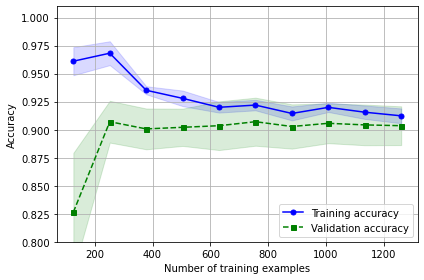

In [327]:
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=LogisticRegression(penalty='none', random_state=1, solver='lbfgs', max_iter=10000, multi_class = 'ovr'),
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.01])
plt.tight_layout()
plt.show()

由上圖可知，在training sample數大約為900時，validation accuracy表現不錯、標準差不大且與training accuracy表現差不多，所以從原始data set取sample數為900/0.9/0.7 ≈ 1428 
將所有label的數目都調到357  
再重新分割data set，30%(428筆)為test data、70%(1000筆)為training data

In [328]:
print("number of labels before([label0 lable1 label2 label3]): %s"% np.bincount(y))

X0_dwsampled, y0_dwsampled = resample(X[y == 0],
                                      y[y == 0],
                                      replace=True,
                                      n_samples=357,
                                      random_state=1)

X1_upsampled, y1_upsampled = resample(X[y == 1],
                                      y[y == 1],
                                      replace=True,
                                      n_samples=357,
                                      random_state=1)

X2_upsampled, y2_upsampled = resample(X[y == 2],
                                      y[y == 2],
                                      replace=True,
                                      n_samples=357,
                                      random_state=1)

X3_upsampled, y3_upsampled = resample(X[y == 3],
                                      y[y == 3],
                                      replace=True,
                                      n_samples=357,
                                      random_state=1)

X_resample = np.vstack((X0_dwsampled, X1_upsampled, X2_upsampled, X3_upsampled))
y_resample = np.hstack((y0_dwsampled, y1_upsampled, y2_upsampled, y3_upsampled))

print("number of labels after([label0 lable1 label2 label3]): %s"% np.bincount(y_resample))

X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, test_size=0.3, random_state=0, stratify=y_resample)

number of labels before([label0 lable1 label2 label3]): [1210  384   69   65]
number of labels after([label0 lable1 label2 label3]): [357 357 357 357]


## Train model
資料處理完後，以logistic regression model初步畫出k-fold v.s. accuracy圖，penalty設none(採用所有原始features)，找出k設多少比較好。最後，再用SVM train出最終model

(0.84, 1.0)

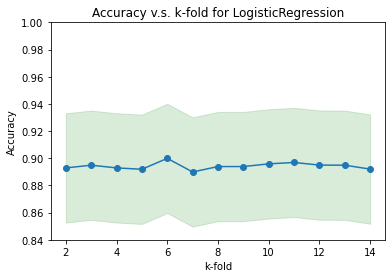

In [329]:
scores_mean, scores_std, params = [], [], []
for c in np.arange(2, 15, 1):
    scores = cross_val_score(estimator=LogisticRegression(penalty='none', random_state=1, solver='lbfgs', max_iter=10000, multi_class = 'ovr'),
                             X=X_train,
                             y=y_train,
                             cv=c,
                             n_jobs=-1)
    score_mean, score_std = np.mean(scores), np.std(scores)
    scores_mean.append(score_mean)
    scores_std.append(score_std)
    params.append(c)
scores = np.array(scores)    

plt.figure()
plt.title('Accuracy v.s. k-fold for LogisticRegression')
plt.plot(params, scores_mean, marker = 'o')
plt.fill_between(params,
                 scores_mean + score_std,
                 scores_mean - score_std,
                 alpha=0.15, color='green')
plt.xlabel('k-fold')
plt.ylabel('Accuracy')
plt.ylim([0.84, 1.0])

由上圖可知，不論k為多少，標準差都差不多，而k=6時，accuracy有略高於其他筆，所以我以3*2-fold corss validation去train model  
再使用support vector machine algorithm，透過grid search方法，找出最適當的kernel、gamma及hyperparameter  
在SVM裡，multi-class classification 只有支援one-vs-one scheme 

In [330]:
pipe_svc = make_pipeline(SVC(random_state=1, probability=True))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=2,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)
print("best accuracy in param_grid:",gs.best_score_)
print("best param_grid:",gs.best_params_)
clf = gs.best_estimator_

scores = cross_val_score(clf, X_train, y_train, 
                         scoring='accuracy', cv=3)

print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))

print('Test accuracy: %.3f' % clf.score(X_test, y_test))

best accuracy in param_grid: 0.9939939879759518
best param_grid: {'svc__C': 100.0, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
CV accuracy: 0.992 +/- 0.006
Test accuracy: 0.995


從grid search可以得知，當hperparameter=100、gamma=0.1、kernel='rbf'時，是最好的model，那個model的accuracy為99.40%  
再用nested cross validation去看training data CV的accuracy，可以得到accuracy為99.2%，標準差為0.006  
而test data accuracy為99.5%

接著用nested cross validation中的內圈(2-fold cross validation)中的model，畫ROC及看ROC的AUC為多少

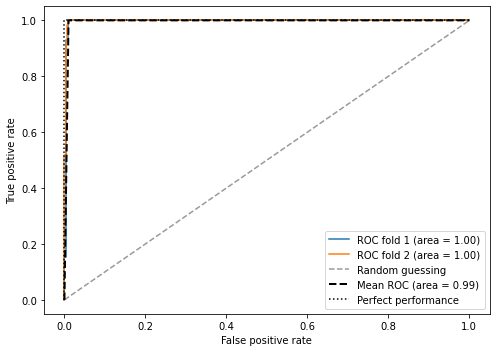

In [331]:
if scipy_version >= Version('1.4.1'):
    from numpy import interp
else:
    from scipy import interp
    

cv = list(StratifiedKFold(n_splits=2).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = clf.fit(X_train[train], y_train[train]).predict_proba(X_train[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

上圖可知，跟第一小題相同，2個fold的AUC都達到將近1，平均area為0.99

## 結論
1. training data CV的accuracy為99.2%，標準差為0.006；test accuracy為99.5%。accuracy很高，且標準差很小，model表現還不錯
2. 計算的決定好要用1428個samples及3*2-fold cross validation後，在grid search的地方，計算量需要  
    kernel: 2種、hyperparameter: 8種、gamma: 8種、cross validation: 3 * 2種  
    排列組合共為2 * 8 * 8 * 3 * 2=768次，代表要計算768次得到最佳parameter及CV accuracy
3. 因為最初要決定sample數及幾個fold cross validation時，不知道SVC的參數要設多少，所以就先透過比較不需要設定那麼多種參數的logistic regression，初步取得合理的sample數及k。雖然取得這兩個數字時和最終使用的model是不同algoriithm，但這兩個參數對整個model影響並不會很大，所以只是先取一個合理的數字
4. 資料處理時，有先將doors中的5more及persons中的more轉換為5，這個轉換可能不夠精準，但是doors及persons中的資料為numerical，又要將含有文字的部分轉換為數字，所以就只能先以這種方式轉換了。另外，因為這兩個features數值的上下界很小，也只有3、4種數值，所以就沒先做standardization 
5. 第一小題只需要判別2種labels，這題需要判別4種不同labels，最後結果training data CV accuracy都很高，同樣達到99.2%。但multi-class的版本標準差略大一點點，multi-class標準差為0.006，而2-class標準差為0.004。而test accuracy這題為99.5%、第一題為100%，有略低於第一題。可能原因為需要更精準的判別不同labels    
---

## (3)
Use feature selection or extraction to develop a model for four group classification.  
Please also prepare some analysis for the model developed in 1.2 and 1.3
(performance, computation complexity required, …).

## 想法
1. 採用support vector machine作為這次model的algorithm，因為SVM主要有兩個參數(C及gamma)可以調，適合套用到grid search上找出最好的parameter
2. 將非數字features，以OneHotEncoder轉換
3. 在logistic regression中multi-class用OVR方法、而SVM只有支援one-vs-one scheme
4. 需要做feature extraction或feature selection。考量到12個features中有10個features是因為OneHotEncoder才產生的，他們互相有關連性，可以看成一組一組的，使用feature selection直接丟掉feature可能不太適合，所以我就直接使用feature extraction來減少feature數目。分別使用PCA及LDA方法，看他們的成效如何
5. 需要決定的參數有sample數、"k"-fold cross validation、C、gamma、n_components

### 資料處理
1. 將label "unacc"轉換為0、"acc"轉換為1，"good"轉換為2、"vgood"轉換為3
2. 因為doors及persons feature數值有裡面又有包含文字，但又有大小之分，並不適合用OneHotEncoder，所以將doors中的5more及persons中的more轉換為5。因為這兩個features數值只有幾種，且數值上下界差異不大，所以不需要做standardization
3. 將buying、maint、lug_boot feature用OneHotEncoder方式，以pandas中的get_dummies轉換，設drop_first = True

做完轉換總共會有12種features

In [332]:
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', header = None)
df.columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'classlabel']

label_mapping = {'unacc': 0, 'acc': 1, 'good': 2, 'vgood': 3}
doors_mapping = {'2': 2, '3': 3, '4': 4, '5more': 5}
persons_mapping = {'2': 2, '4': 4, 'more': 5}

df['classlabel'] = df['classlabel'].map(label_mapping)
df['doors'] = df['doors'].map(doors_mapping)
df['persons'] = df['persons'].map(persons_mapping)
df = pd.get_dummies(df, drop_first=True)
print(df)

X = df.iloc[:, np.r_[0:2, 3:13]].values
y = df.iloc[:, 2].values

      doors  persons  classlabel  buying_low  buying_med  buying_vhigh  \
0         2        2           0           0           0             1   
1         2        2           0           0           0             1   
2         2        2           0           0           0             1   
3         2        2           0           0           0             1   
4         2        2           0           0           0             1   
...     ...      ...         ...         ...         ...           ...   
1723      5        5           2           1           0             0   
1724      5        5           3           1           0             0   
1725      5        5           0           1           0             0   
1726      5        5           2           1           0             0   
1727      5        5           3           1           0             0   

      maint_low  maint_med  maint_vhigh  lug_boot_med  lug_boot_small  \
0             0          0            

有1210個samples label為0、384個samples label為1、69個samples label為3、65個samples label為4  
比例相差太懸殊，所以使用resample方法，先把四種labels都調成500個，之後會藉由learning curve取適當的sample數，並取30%為test data，70%為training data  

In [333]:
print("number of labels before([label0 lable1 label2 label3]): %s"% np.bincount(y))

X0_dwsampled, y0_dwsampled = resample(X[y == 0],
                                      y[y == 0],
                                      replace=True,
                                      n_samples=500,
                                      random_state=1)

X1_upsampled, y1_upsampled = resample(X[y == 1],
                                      y[y == 1],
                                      replace=True,
                                      n_samples=500,
                                      random_state=1)

X2_upsampled, y2_upsampled = resample(X[y == 2],
                                      y[y == 2],
                                      replace=True,
                                      n_samples=500,
                                      random_state=1)

X3_upsampled, y3_upsampled = resample(X[y == 3],
                                      y[y == 3],
                                      replace=True,
                                      n_samples=500,
                                      random_state=1)

X_resample = np.vstack((X0_dwsampled, X1_upsampled, X2_upsampled, X3_upsampled))
y_resample = np.hstack((y0_dwsampled, y1_upsampled, y2_upsampled, y3_upsampled))

print("number of labels after([label0 lable1 label2 label3]): %s"% np.bincount(y_resample))

X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, test_size=0.3, random_state=0, stratify=y_resample)

number of labels before([label0 lable1 label2 label3]): [1210  384   69   65]
number of labels after([label0 lable1 label2 label3]): [500 500 500 500]


接著，要決定sample數取多少比較合理。由於此時不知道SVC的參數要設多少，所以就先透過比較不需要設定那麼多種參數的logistic regression，初步取得合理的smple數及k    
用learning curve，以logistic regression model初步畫出sample v.s. accuracy圖，penalty設none(採用所有原始features)、multi_class設'ovr'、先用10-fold cross-validation，取出適當的sample數

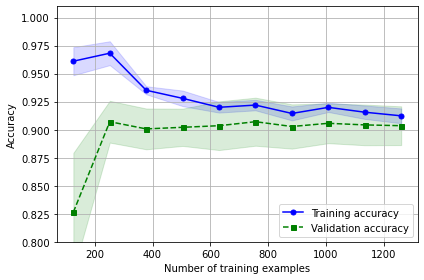

In [334]:
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=LogisticRegression(penalty='none', random_state=1, solver='lbfgs', max_iter=10000, multi_class = 'ovr'),
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.01])
plt.tight_layout()
plt.show()

由上圖可知，在training sample數大約為900時，validation accuracy表現不錯、標準差不大且與training accuracy表現差不多，所以從原始data set取sample數為900/0.9/0.7 ≈ 1428 
將所有label的數目都調到357  
再重新分割data set，30%(428筆)為test data、70%(1000筆)為training data

In [335]:
print("number of labels before([label0 lable1 label2 label3]): %s"% np.bincount(y))

X0_dwsampled, y0_dwsampled = resample(X[y == 0],
                                      y[y == 0],
                                      replace=True,
                                      n_samples=357,
                                      random_state=1)

X1_upsampled, y1_upsampled = resample(X[y == 1],
                                      y[y == 1],
                                      replace=True,
                                      n_samples=357,
                                      random_state=1)

X2_upsampled, y2_upsampled = resample(X[y == 2],
                                      y[y == 2],
                                      replace=True,
                                      n_samples=357,
                                      random_state=1)

X3_upsampled, y3_upsampled = resample(X[y == 3],
                                      y[y == 3],
                                      replace=True,
                                      n_samples=357,
                                      random_state=1)

X_resample = np.vstack((X0_dwsampled, X1_upsampled, X2_upsampled, X3_upsampled))
y_resample = np.hstack((y0_dwsampled, y1_upsampled, y2_upsampled, y3_upsampled))

print("number of labels after([label0 lable1 label2 label3]): %s"% np.bincount(y_resample))

X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, test_size=0.3, random_state=0, stratify=y_resample)

number of labels before([label0 lable1 label2 label3]): [1210  384   69   65]
number of labels after([label0 lable1 label2 label3]): [357 357 357 357]


因為12種features太多了，需要做feature extraction或feature selection。考量到12個features中有10個features是因為OneHotEncoder才產生的，他們互相有關連性，可以看成一組一組的，使用feature selection直接丟掉feature可能不太適合，所以我就直接使用feature extraction來減少feature數目。  
先分別畫出PCA及LDA Principal components v.s. explained_variance_ratio的圖，決定n_component要設多少  

explained variance ratio of principal components: 
[0.30590426 0.22657775 0.10387334 0.08337681 0.07056625 0.05837412
 0.04379225 0.038187   0.02924769 0.01940312 0.01142524 0.00927218]


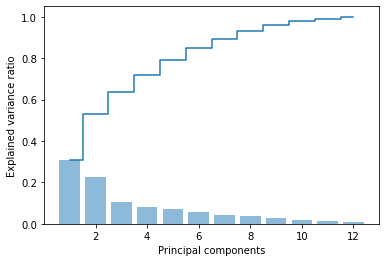

In [336]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train) 
print("explained variance ratio of principal components: ")
print(pca.explained_variance_ratio_)


plt.bar(range(1, 13), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 13), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')

plt.show()

explained variance ratio of principal components: 
[0.79149604 0.11292905 0.09557491]


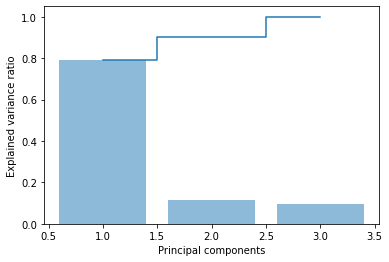

In [337]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA()
X_train_lda = lda.fit_transform(X_train, y_train)
print("explained variance ratio of principal components: ")
print(lda.explained_variance_ratio_)

plt.bar(range(1, 4), lda.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 4), np.cumsum(lda.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')

plt.show()

若要選取PCA，選取大概累加到explained variance ratio為60%的components，會選前3個pricipal components去做training  
若要選取LDA，因為LDA有between class的限制，共有4種labels只會留下3種linear discriminants，所以就選取全部的principal components做training

## Using PCA

用PCA方法降低features數，設n_components = 3  

In [338]:
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

資料處理完後，以logistic regression model初步畫出k-fold v.s. accuracy圖，penalty設none(採用所有原始features)，找出k設多少比較好。最後，再用SVM train出最終model

(0.2, 0.5)

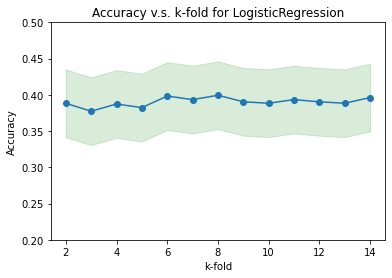

In [339]:
scores_mean, scores_std, params = [], [], []
for c in np.arange(2, 15, 1):
    scores = cross_val_score(estimator=LogisticRegression(penalty='none', random_state=1, solver='lbfgs', max_iter=10000, multi_class = 'ovr'),
                             X=X_train_pca,
                             y=y_train,
                             cv=c,
                             n_jobs=-1)
    score_mean, score_std = np.mean(scores), np.std(scores)
    scores_mean.append(score_mean)
    scores_std.append(score_std)
    params.append(c)
scores = np.array(scores)  


plt.figure()
plt.title('Accuracy v.s. k-fold for LogisticRegression')
plt.plot(params, scores_mean, marker = 'o')
plt.fill_between(params,
                 scores_mean + score_std,
                 scores_mean - score_std,
                 alpha=0.15, color='green')
plt.xlabel('k-fold')
plt.ylabel('Accuracy')
plt.ylim([0.2, 0.5])

accuracy意外的只有40%上下，我猜想可能是n_components設太小，用迴圈畫Accuracy v.s. n_components圖，看看accuracy趨勢如何

(0.2, 1.0)

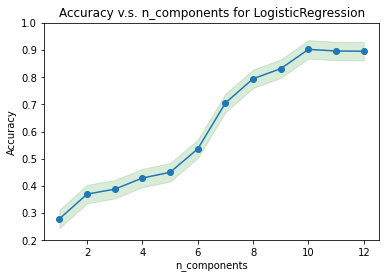

In [340]:
scores_mean, scores_std, params = [], [], []
for c in np.arange(1, 13, 1):
    pca = PCA(n_components=c)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    scores = cross_val_score(estimator=LogisticRegression(penalty='none', random_state=1, solver='lbfgs', max_iter=10000, multi_class = 'ovr'),
                             X=X_train_pca,
                             y=y_train,
                             cv=10,
                             n_jobs=-1)
    score_mean, score_std = np.mean(scores), np.std(scores)
    scores_mean.append(score_mean)
    scores_std.append(score_std)
    params.append(c)
scores_mean = np.array(scores_mean)  

plt.figure()
plt.title('Accuracy v.s. n_components for LogisticRegression')
plt.plot(params, scores_mean, marker = 'o')
plt.fill_between(params,
                 scores_mean + score_std,
                 scores_mean - score_std,
                 alpha=0.15, color='green')
plt.xlabel('n_components')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1])

由上圖可知n_components應該要設到10，accuracy才會穩定在高點。接著，在畫k-fold v.s. accuracy圖，penalty設none(採用所有原始features)，找出k設多少比較好。最後，再用SVM train出最終model

(0.8, 1.0)

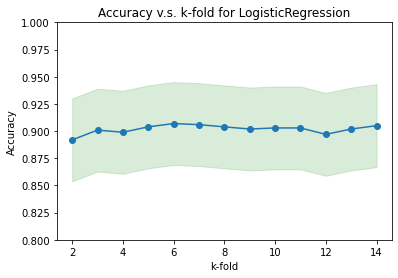

In [341]:
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

scores_mean, scores_std, params = [], [], []
for c in np.arange(2, 15, 1):
    scores = cross_val_score(estimator=LogisticRegression(penalty='none', random_state=1, solver='lbfgs', max_iter=10000, multi_class = 'ovr'),
                             X=X_train_pca,
                             y=y_train,
                             cv=c,
                             n_jobs=-1)
    score_mean, score_std = np.mean(scores), np.std(scores)
    scores_mean.append(score_mean)
    scores_std.append(score_std)
    params.append(c)
scores_mean = np.array(scores_mean)    

plt.figure()
plt.title('Accuracy v.s. k-fold for LogisticRegression')
plt.plot(params, scores_mean, marker = 'o')
plt.fill_between(params,
                 scores_mean + score_std,
                 scores_mean - score_std,
                 alpha=0.15, color='green')
plt.xlabel('k-fold')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])

由上圖可知，不論k為多少，標準差都差不多，而k=6時，accuracy有略高於其他筆，所以我以3*2-fold corss validation去train model  
再使用support vector machine algorithm，透過grid search方法，找出最適當的kernel、gamma及hyperparameter  
在SVM裡，multi-class classification 只有支援one-vs-one scheme 

In [342]:
pipe_svc = make_pipeline(SVC(random_state=1, probability=True))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=2,
                  n_jobs=-1)

gs = gs.fit(X_train_pca, y_train)
print("best accuracy in param_grid:",gs.best_score_)
print("best param_grid:",gs.best_params_)
clf = gs.best_estimator_

scores = cross_val_score(clf, X_train_pca, y_train, 
                         scoring='accuracy', cv=3)

print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))

print('Test accuracy: %.3f' % clf.score(X_test_pca, y_test))

best accuracy in param_grid: 0.9879819639278558
best param_grid: {'svc__C': 100.0, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
CV accuracy: 0.987 +/- 0.001
Test accuracy: 1.000


從grid search可以得知，當hperparameter=100、gamma=0.1、kernel='rbf'時，是最好的model，那個model的accuracy為98.80%  
再用nested cross validation去看training data CV的accuracy，可以得到accuracy為98.7%，標準差為0.001  
而test data accuracy為100%

接著用nested cross validation中的內圈(2-fold cross validation)中的model，畫ROC及看ROC的AUC為多少

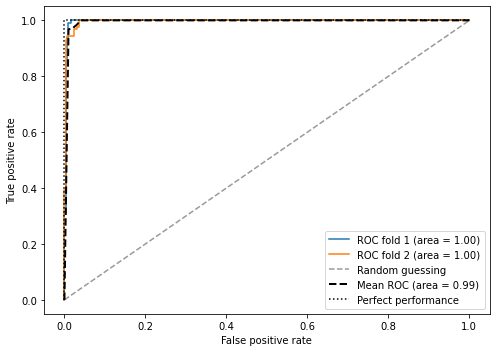

In [343]:
if scipy_version >= Version('1.4.1'):
    from numpy import interp
else:
    from scipy import interp
    

cv = list(StratifiedKFold(n_splits=2).split(X_train_pca, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = clf.fit(X_train_pca[train], y_train[train]).predict_proba(X_train_pca[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

上圖可知，2個fold的AUC都達到將近1，平均area為0.99

## Using LDA

用LDA方法降低features數，設n_components = 3  

In [344]:
lda = LDA(n_components=3)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

資料處理完後，以logistic regression model初步畫出k-fold v.s. accuracy圖，penalty設none(採用所有原始features)，找出k設多少比較好。最後，再用SVM train出最終model

(0.85, 1.0)

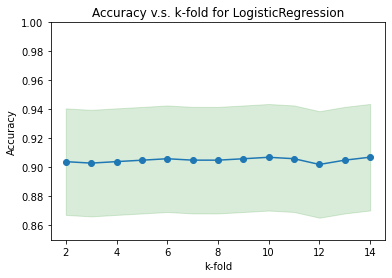

In [345]:
scores_mean, scores_std, params = [], [], []
for c in np.arange(2, 15, 1):
    scores = cross_val_score(estimator=LogisticRegression(penalty='none', random_state=1, solver='lbfgs', max_iter=10000, multi_class = 'ovr'),
                             X=X_train_lda,
                             y=y_train,
                             cv=c,
                             n_jobs=-1)
    score_mean, score_std = np.mean(scores), np.std(scores)
    scores_mean.append(score_mean)
    scores_std.append(score_std)
    params.append(c)
scores = np.array(scores)  


plt.figure()
plt.title('Accuracy v.s. k-fold for LogisticRegression')
plt.plot(params, scores_mean, marker = 'o')
plt.fill_between(params,
                 scores_mean + score_std,
                 scores_mean - score_std,
                 alpha=0.15, color='green')
plt.xlabel('k-fold')
plt.ylabel('Accuracy')
plt.ylim([0.85, 1.0])

由上圖可知，不論k為多少，標準差及accuracy都差不多，所以我直接跟PCA一樣取k=6，以3*2-fold corss validation去train model  
再使用support vector machine algorithm，透過grid search方法，找出最適當的kernel、gamma及hyperparameter  
在SVM裡，multi-class classification 只有支援one-vs-one scheme 

In [346]:
pipe_svc = make_pipeline(SVC(random_state=1, probability=True))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=2,
                  n_jobs=-1)

gs = gs.fit(X_train_lda, y_train)
print("best accuracy in param_grid:",gs.best_score_)
print("best param_grid:",gs.best_params_)
clf = gs.best_estimator_

scores = cross_val_score(clf, X_train_lda, y_train, 
                         scoring='accuracy', cv=3)

print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))

print('Test accuracy: %.3f' % clf.score(X_test_lda, y_test))

best accuracy in param_grid: 0.9739699398797594
best param_grid: {'svc__C': 10.0, 'svc__gamma': 1.0, 'svc__kernel': 'rbf'}
CV accuracy: 0.979 +/- 0.006
Test accuracy: 0.974


從grid search可以得知，當hperparameter=10、gamma=1、kernel='rbf'時，是最好的model，那個model的accuracy為97.40%  
再用nested cross validation去看training data CV的accuracy，可以得到accuracy為97.9%，標準差為0.006  
而test data accuracy為97.4%

接著用nested cross validation中的內圈(2-fold cross validation)中的model，畫ROC及看ROC的AUC為多少

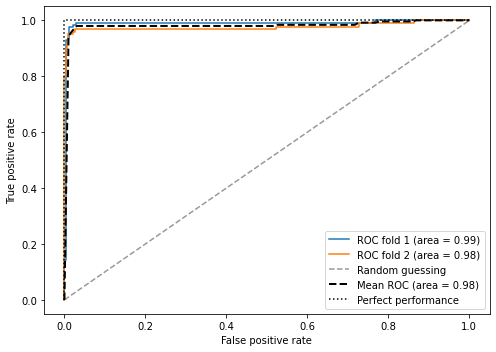

In [347]:
if scipy_version >= Version('1.4.1'):
    from numpy import interp
else:
    from scipy import interp
    

cv = list(StratifiedKFold(n_splits=2).split(X_train_lda, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = clf.fit(X_train_lda[train], y_train[train]).predict_proba(X_train_lda[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

上圖可知，2個fold的AUC分別為0.99及0.98，平均area為0.98

## 結論
1. PCA test accuracy為100%；LDA test accuracy為97.4%。accuracy很高，model表現還不錯
2. 不論是在PCA或LDA計算的決定好要用1428個samples及3*2-fold cross validation後，在grid search的地方，計算量需要  
    kernel: 2種、hyperparameter: 8種、gamma: 8種、cross validation: 3 * 2種  
    排列組合共為2 * 8 * 8 * 3 * 2=768次，代表要計算768次得到最佳parameter及CV accuracy  
    但PCA使用了10個principal components、LDA只有用3個principal components，LDA計算速度會較PCA高
3. 因為最初要決定sample數及幾個fold cross validation時，不知道SVC的參數要設多少，所以就先透過比較不需要設定那麼多種參數的logistic regression，初步取得合理的sample數及k。雖然取得這兩個數字時和最終使用的model是不同algoriithm，但這兩個參數對整個model影響並不會很大，所以只是先取一個合理的數字
4. 資料處理時，有先將doors中的5more及persons中的more轉換為5，這個轉換可能不夠精準，但是doors及persons中的資料為numerical，又要將含有文字的部分轉換為數字，所以就只能先以這種方式轉換了。另外，因為這兩個features數值的上下界很小，也只有3、4種數值，所以就沒先做standardization 
5. 做了feature extraction accuracy跟前面使用所有features差不多，都一樣很高。但在feature extraction後，因為feature數目減少，可以加快運算速度，比較節省時間
6. PCA test accuracy略高於LDA，可能原因為PCA使用的principal components比較多，做feature extraction保留原本feature較多的資訊。但LDA所需的運算量會比PCA少